In [1]:
%matplotlib notebook

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import qcodes as qc
from pprint import pprint
from importlib import reload
import lmfit

In [9]:
from pytopo.mplplots import init_nb_plotting; reload(init_nb_plotting)
from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots, tools as plottools

from plottr.data import qcodes; reload(qcodes)
from plottr.data.qcodes import DataSetDict

# Global settings

In [3]:
qc.config['core']['db_location']

'd:/data/qcodes2/experiments.db'

# Resonator spec

In [32]:
run_id = 282

data = DataSetDict(run_id=run_id)
pprint(data.structure())

{'avgiq_detector_channels': {'axes': [], 'unit': ''},
 'avgiq_detector_signal_abs': {'axes': ['het_src_frequency',
                                        'ro_attenuator_attenuation',
                                        'awg_spec_sweep_awg_sweep_idx',
                                        'avgiq_detector_channels'],
                               'unit': 'V'},
 'avgiq_detector_signal_imag': {'axes': ['het_src_frequency',
                                         'ro_attenuator_attenuation',
                                         'awg_spec_sweep_awg_sweep_idx',
                                         'avgiq_detector_channels'],
                                'unit': 'V'},
 'avgiq_detector_signal_real': {'axes': ['het_src_frequency',
                                         'ro_attenuator_attenuation',
                                         'awg_spec_sweep_awg_sweep_idx',
                                         'avgiq_detector_channels'],
                                'unit

In [33]:
data_real = dict(data.get_grid('avgiq_detector_signal_real'))
data_imag = dict(data.get_grid('avgiq_detector_signal_imag'))

sig_vals = np.squeeze(data_real['avgiq_detector_signal_real'] + 1j * data_imag['avgiq_detector_signal_imag'])[..., 1]

<IPython.core.display.Javascript object>


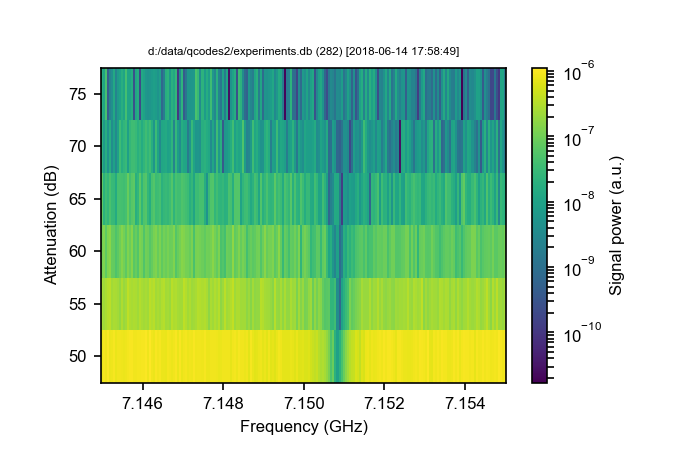

Text(0.5,1,'d:/data/qcodes2/experiments.db (282) [2018-06-14 17:58:49]')

In [34]:
fig, ax = plt.subplots(1,1)
im = plots.ppcolormesh(
    ax, 
    data_real['het_src_frequency'] * 1e-9, 
    data_real['ro_attenuator_attenuation'],
    np.abs(sig_vals.T)**2,
    norm=mpl.colors.LogNorm(),
)
cb = fig.colorbar(im)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Attenuation (dB)')
cb.set_label('Signal power (a.u.)')
ax.set_title(data.dslabel_short(), size='x-small')

<IPython.core.display.Javascript object>


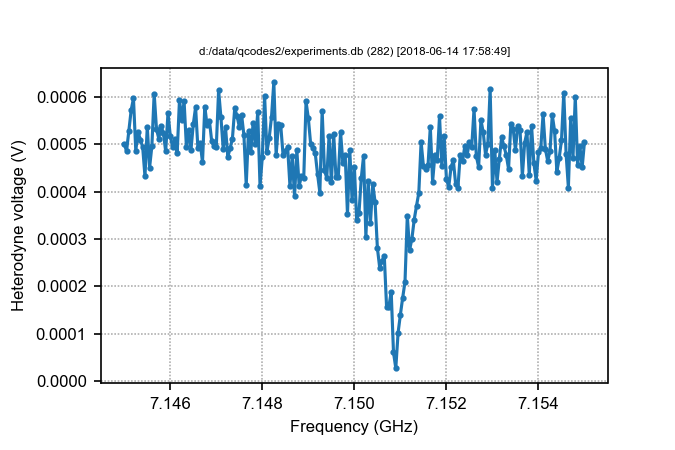

Text(0.5,1,'d:/data/qcodes2/experiments.db (282) [2018-06-14 17:58:49]')

In [35]:
fig, ax = plt.subplots(1,1)
ax.plot(
    data_real['het_src_frequency'] * 1e-9, 
    np.abs(sig_vals[:, 1]),
    'o-', ms=2,
)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Heterodyne voltage (V)')
ax.grid(dashes=[1,1])
ax.set_title(data.dslabel_short(), size='x-small')

# RO-power dependent 2-tone

In [42]:
run_id = 284

data = DataSetDict(run_id=run_id)
pprint(data.structure())

{'avgiq_detector_channels': {'axes': [], 'unit': ''},
 'avgiq_detector_signal_abs': {'axes': ['qubit_gen_frequency',
                                        'ro_attenuator_attenuation',
                                        'awg_spec_sweep_awg_sweep_idx',
                                        'avgiq_detector_channels'],
                               'unit': 'V'},
 'avgiq_detector_signal_imag': {'axes': ['qubit_gen_frequency',
                                         'ro_attenuator_attenuation',
                                         'awg_spec_sweep_awg_sweep_idx',
                                         'avgiq_detector_channels'],
                                'unit': 'V'},
 'avgiq_detector_signal_real': {'axes': ['qubit_gen_frequency',
                                         'ro_attenuator_attenuation',
                                         'awg_spec_sweep_awg_sweep_idx',
                                         'avgiq_detector_channels'],
                               

<IPython.core.display.Javascript object>


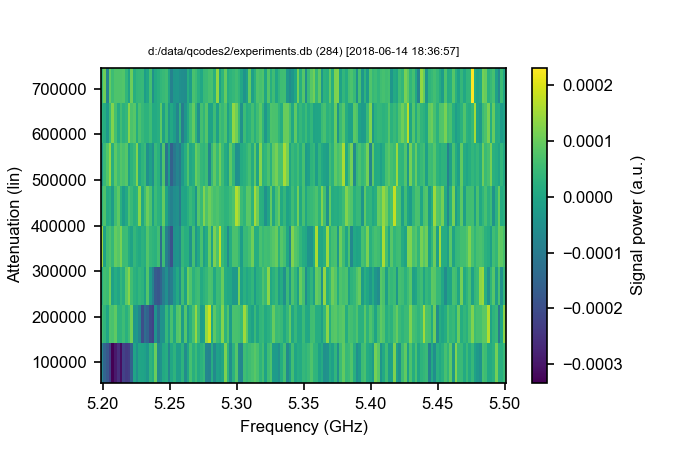

Text(0.5,1,'d:/data/qcodes2/experiments.db (284) [2018-06-14 18:36:57]')

In [61]:
data_real = dict(data.get_grid('avgiq_detector_signal_real'))
data_imag = dict(data.get_grid('avgiq_detector_signal_imag'))

sig_vals = np.squeeze(data_real['avgiq_detector_signal_real'] + 1j * data_imag['avgiq_detector_signal_imag'])[..., 1]


fig, ax = plt.subplots(1,1)
im = plots.ppcolormesh(
    ax, 
    data_real['qubit_gen_frequency'] * 1e-9, 
    10**(data_real['ro_attenuator_attenuation'][:-2]/10.),
    sig_vals.real[:,:-2].T,
#     norm=mpl.colors.LogNorm(),
)
cb = fig.colorbar(im)
# ax.set_yscale('log')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Attenuation (lin)')
cb.set_label('Signal power (a.u.)')
ax.set_title(data.dslabel_short(), size='x-small')

array([ 100000.        ,  188364.90894898,  266072.50597988,
        354813.38923358,  446683.59215096,  530884.44423099,
        630957.34448019,  707945.78438414,  794328.23472428,
        891250.93813375])

# T1 with continous readout

In [19]:
run_id = 215

data = DataSetDict(run_id=run_id)
pprint(data.structure())

{'demodrel_detector_IF_periods': {'axes': [], 'unit': ''},
 'demodrel_detector_signal_abs': {'axes': ['qubit_gen_frequency',
                                           'qspec_sweep_awg_sweep_idx',
                                           'demodrel_detector_IF_periods'],
                                  'unit': 'V'},
 'demodrel_detector_signal_imag': {'axes': ['qubit_gen_frequency',
                                            'qspec_sweep_awg_sweep_idx',
                                            'demodrel_detector_IF_periods'],
                                   'unit': 'V'},
 'demodrel_detector_signal_real': {'axes': ['qubit_gen_frequency',
                                            'qspec_sweep_awg_sweep_idx',
                                            'demodrel_detector_IF_periods'],
                                   'unit': 'V'},
 'qspec_sweep_awg_sweep_idx': {'axes': [], 'unit': ''},
 'qubit_gen_frequency': {'axes': [], 'unit': 'Hz'}}


In [5]:
def t1_decay(x, tau, amp, of):
    return amp * np.exp(-x/tau) + of

t1_model = lmfit.Model(t1_decay)

<IPython.core.display.Javascript object>


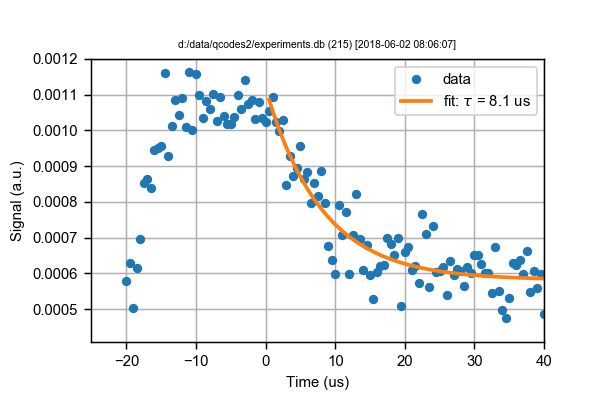

[[Model]]
    Model(t1_decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 165
    # variables        = 3
    chi-square         = 6.8581e-07
    reduced chi-square = 4.2334e-09
    Akaike info crit   = -3178.27087
    Bayesian info crit = -3168.95303
[[Variables]]
    tau:  8.07068078 +/- 0.81728603 (10.13%) (init = 5)
    amp:  5.3677e-04 +/- 3.4513e-05 (6.43%) (init = 0.001)
    of:   5.8148e-04 +/- 6.4914e-06 (1.12%) (init = 0.0005)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau, amp) = -0.646
    C(tau, of)  = -0.493



Text(0.5,1,'d:/data/qcodes2/experiments.db (215) [2018-06-02 08:06:07]')

In [30]:
datar = dict(data.get_grid('demodrel_detector_signal_real'))
datai = dict(data.get_grid('demodrel_detector_signal_imag'))

sigvals = np.squeeze(datar['demodrel_detector_signal_real'] + 1j * datai['demodrel_detector_signal_imag'])
sigvals = sigvals[12, ...] # choose idx where i believe we're on resonance
tvals = datar['demodrel_detector_IF_periods'] * 0.05 - 20 # conversion to us and start decay at 0.

# rebin this
bins = 10
tvals = tvals[::bins]
sigvals = sigvals.reshape(-1, bins).mean(axis=-1)
sigvals = np.abs(sigvals)

fig, ax = plt.subplots(1,1)
ax.plot(tvals, sigvals, 'o', label='data')

# fit
if True:
    fitres = t1_model.fit(sigvals[tvals>0], x=tvals[tvals>0], tau=5, amp=1e-3, of=5e-4)
    ax.plot(tvals[tvals>0], fitres.best_fit, lw=2,
            label=r'fit: $\tau$ = {:.1f} us'.format(fitres.params['tau'].value))
    print(fitres.fit_report())
    


ax.set_xlabel('Time (us)')
ax.set_ylabel('Signal (a.u.)')
ax.legend(loc='best')
ax.grid()

ax.set_xlim(None, 40)

ax.set_title(data.dslabel_short(), size='x-small')

# Pulsed T1

In [97]:
run_id = 264

data = DataSetDict(run_id=run_id)
pprint(data.structure())

{'iqrel_detector_signal_abs': {'axes': ['iqrel_detector_soft_average',
                                        't1_sweep_delay'],
                               'unit': 'V'},
 'iqrel_detector_signal_imag': {'axes': ['iqrel_detector_soft_average',
                                         't1_sweep_delay'],
                                'unit': 'V'},
 'iqrel_detector_signal_real': {'axes': ['iqrel_detector_soft_average',
                                         't1_sweep_delay'],
                                'unit': 'V'},
 'iqrel_detector_soft_average': {'axes': [], 'unit': ''},
 't1_sweep_delay': {'axes': [], 'unit': 's'}}


<IPython.core.display.Javascript object>


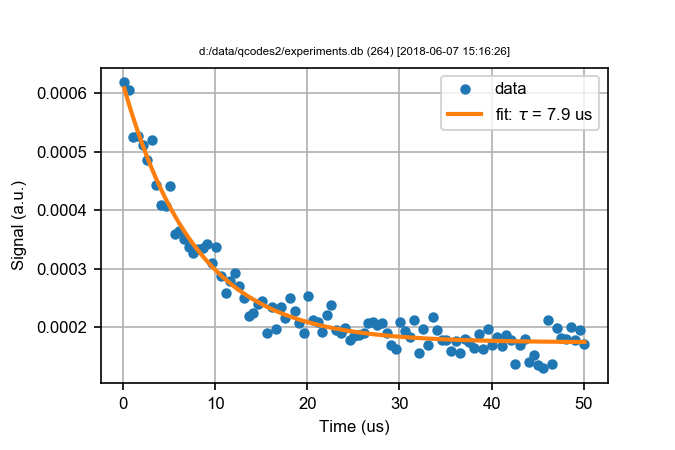

[[Model]]
    Model(t1_decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 101
    # variables        = 3
    chi-square         = 4.3144e-08
    reduced chi-square = 4.4024e-10
    Akaike info crit   = -2172.95861
    Bayesian info crit = -2165.11325
[[Variables]]
    tau:  7.88737724 +/- 0.34979643 (4.43%) (init = 5)
    amp:  4.3974e-04 +/- 1.0192e-05 (2.32%) (init = 0.0005)
    of:   1.7406e-04 +/- 3.3428e-06 (1.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau, of)  = -0.658
    C(tau, amp) = -0.498



Text(0.5,1,'d:/data/qcodes2/experiments.db (264) [2018-06-07 15:16:26]')

In [98]:
data = DataSetDict(run_id=run_id)
datar = dict(data.get_grid('iqrel_detector_signal_real'))
datai = dict(data.get_grid('iqrel_detector_signal_imag'))

sigvals = np.squeeze(datar['iqrel_detector_signal_real'] \
                        + 0 * 1j*datai['iqrel_detector_signal_imag']).mean(axis=0)

sigvals = np.abs(sigvals)
tvals = datar['t1_sweep_delay'] * 1e6

fig, ax = plt.subplots(1,1)
ax.plot(tvals, sigvals, 'o', label='data')

# fit
if True:
    fitres = t1_model.fit(sigvals, x=tvals, tau=5, amp=5e-4, of=0)
    ax.plot(tvals, fitres.best_fit, lw=2,
            label=r'fit: $\tau$ = {:.1f} us'.format(fitres.params['tau'].value))
    print(fitres.fit_report())
    


ax.set_xlabel('Time (us)')
ax.set_ylabel('Signal (a.u.)')
ax.legend(loc='best')
ax.grid()

# ax.set_xlim(None, 40)

ax.set_title(data.dslabel_short(), size='x-small')

# Ramsey

In [90]:
run_id = 257

data = DataSetDict(run_id=run_id)
pprint(data.structure())

{'iqrel_detector_signal_abs': {'axes': ['iqrel_detector_soft_average',
                                        'ramsey_sweep_delay'],
                               'unit': 'V'},
 'iqrel_detector_signal_imag': {'axes': ['iqrel_detector_soft_average',
                                         'ramsey_sweep_delay'],
                                'unit': 'V'},
 'iqrel_detector_signal_real': {'axes': ['iqrel_detector_soft_average',
                                         'ramsey_sweep_delay'],
                                'unit': 'V'},
 'iqrel_detector_soft_average': {'axes': [], 'unit': ''},
 'ramsey_sweep_delay': {'axes': [], 'unit': 's'}}


<IPython.core.display.Javascript object>


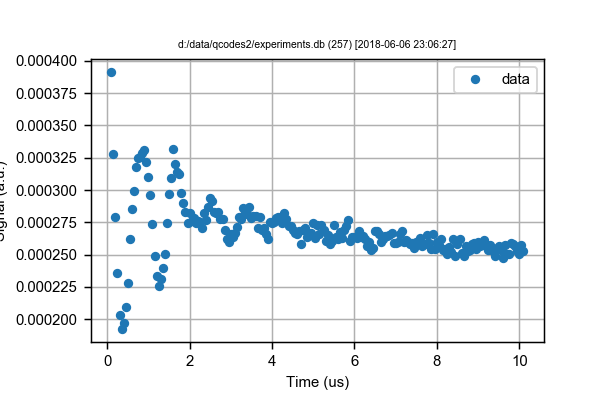

Text(0.5,1,'d:/data/qcodes2/experiments.db (257) [2018-06-06 23:06:27]')

In [91]:
data = DataSetDict(run_id=run_id)
datar = dict(data.get_grid('iqrel_detector_signal_real'))
datai = dict(data.get_grid('iqrel_detector_signal_imag'))

sigvals = np.squeeze(datar['iqrel_detector_signal_real'] \
                        + 0 * 1j*datai['iqrel_detector_signal_imag']).mean(axis=0)

sigvals = np.abs(sigvals)
tvals = datar['ramsey_sweep_delay'] * 1e6

fig, ax = plt.subplots(1,1)
ax.plot(tvals, sigvals, 'o', label='data')


ax.set_xlabel('Time (us)')
ax.set_ylabel('Signal (a.u.)')
ax.legend(loc='best')
ax.grid()

# ax.set_xlim(None, 40)

ax.set_title(data.dslabel_short(), size='x-small')

In [96]:
np.ma.masked_where?